# Clickbait spoiling 🖱️
Task description: https://pan.webis.de/semeval23/pan23-web/clickbait-challenge.html (task 2)

Data: https://zenodo.org/record/6362726#.YsbdSTVBzrk

In [1]:
import pandas as pd
from transformers import pipeline, BertTokenizer
import torch 
from torch.utils.data import DataLoader
import torch.optim as optim

from src.data import read_data, read_spoilers, read_data_classification
from src.inference import run_inference, best_query, get_spoiler_from_user_input
from src.evaluation import eval_task_2, plot_scores, plot_comparison_scores
from src.bert_classifier import BertDataset, BERTClassifier, finetune_BERT, predict_spoiler_class_from_text
from src.qa_training import finetune_roberta

from pygaggle.rerank.transformer import MonoT5, MonoBERT

2023-06-02 20:08:26.507175: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2023-06-02 20:08:26.507188: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
DEVICE = "cuda"

## Evaluation
We will use methods inspired on script provided by SemEval23 organizers to evaluate our approaches. The function takes data in the form of JSONL file with columns `uuid` and `spoiler`.

The modules calculates two scores:
1. [BLEU](https://pl.wikipedia.org/wiki/BLEU): Quality is considered to be the correspondence between a machine's output and that of a human, the higher the better. The score takes values between 0 and 1.
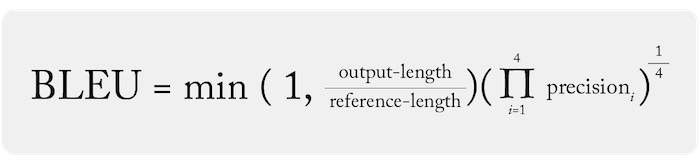
2. [BERT](https://github.com/Tiiiger/bert_score): Leverages the pre-trained contextual embeddings from BERT and matches words in candidate and reference sentences by cosine similarity. The range is -1 to 1.
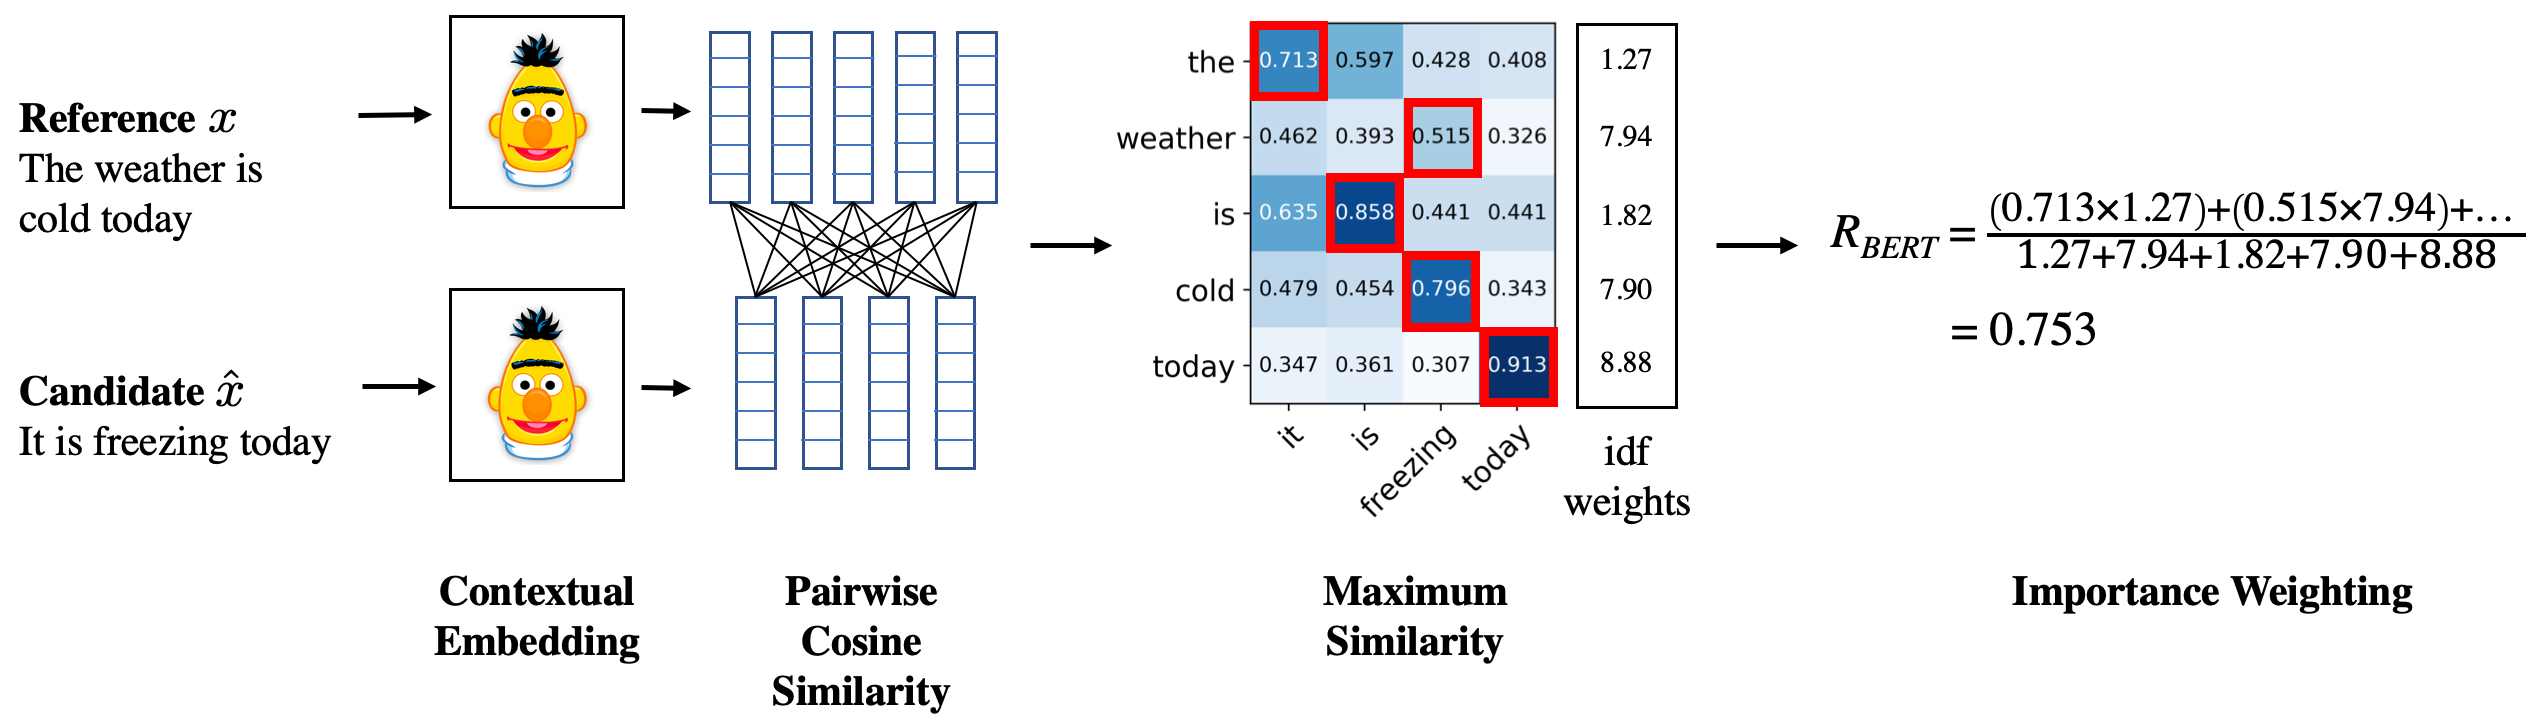

## Spoiler-type classification
The approach based on [Clickbait Spoiling via Question Answering and Passage Retrieval](https://aclanthology.org/2022.acl-long.484) (Hagen et al., ACL 2022) where firstly a spoiler is classified as "phrase", "passage", "multi" and depending on the classification either QA or PR problem is solved. 

Here, we'll use BERT for the classification part (the classificatin is either `phrase` or `passage` - meaning 'passage'/'multi'[multi passage]).

### Fine-Tuning BERT

In [3]:
MODEL_CHECKPOINT = "bert-base-uncased"

train_classification = read_data_classification("data/train.jsonl")
tokenizer = BertTokenizer.from_pretrained(MODEL_CHECKPOINT)

dataset = BertDataset(tokenizer, train_classification)
dataloader = DataLoader(dataset=dataset, batch_size=32)

# model = BERTClassifier(MODEL_CHECKPOINT)
# model = finetune_BERT(10, dataloader, model)

In [5]:
# load the model
PATH = "models/bert_100_epochs.pt"
model = BERTClassifier(MODEL_CHECKPOINT)
model.load_state_dict(torch.load(PATH, map_location=torch.device(DEVICE)))
model.eval();

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
validation_df = read_data("data/validation.jsonl")
validation_df.head(3)

,uuid,title,question,context,sentences,context_classification,spoiler,positions,tags
0,6dc7ddef-4e8e-4a6b-9296-526377518071,Five Nights at Freddy’s Sequel Delayed for Wei...,Five Nights at Freddy’s Sequel Delayed for Wei...,[Five Nights at Freddy’s creator Scott Cawthon...,[Five Nights at Freddy’s creator Scott Cawthon...,Five Nights at Freddy’s Sequel Delayed for Wei...,some of the plot elements are so disturbing th...,"[[[2, 158], [2, 236]]]",0
1,435b24de-56f6-4d4e-9c38-54b8e0630aac,Why Arizona Sheriff Joe Arpaio’s fate could ha...,Why Arizona Sheriff Joe Arpaio’s fate could ha...,[© REUTERS/Laura Segall Maricopa County Sherif...,[© REUTERS/Laura Segall Maricopa County Sherif...,Why Arizona Sheriff Joe Arpaio’s fate could ha...,"""intentionally"" could transform a court case a...","[[[0, 197], [0, 212]], [[0, 215], [0, 328]]]",0
2,8091ba93-6376-473a-9117-01d6cf0507e4,Here’s how much you should be tipping your hai...,Here’s how much you should be tipping your hai...,[Here’s how much you should be tipping your ha...,[Here’s how much you should be tipping your ha...,Here’s how much you should be tipping your hai...,20%,"[[[3, 58], [3, 61]]]",1


In [11]:
# EXAMPLE PASSAGE (1 - "phrase", 0 - "passage"/"multi")
x = 123

text = validation_df.iloc[x]["context_classification"]
tag = validation_df.iloc[x]["tags"]
print(text)

prediction = predict_spoiler_class_from_text(text, model, MODEL_CHECKPOINT)
print(f'True label: {tag}, predicted label: {prediction}')

This guy went on a holiday with a group of total strangers for the greatest reason For Nathan’s birthday, nine of his friends planned a trip to Majorca. But unfortunately one of them, Joe McGrath, bailed. Instead of having to look at one empty seat all week, the group of friends decided to take matters into their own hands, and find a new Joe McGrath to take with them. One of the group messaged some Joe McGraths on Facebook. He wrote: Would you consider coming on holiday with a group of nine strangers if they had already arranged flights for you and an all inclusive hotel? It’s our friend Nathan’s 30th birthday and we decided to throw him a surprise holiday break in Mallorca. They asked 15 namesakes, but only this one said yes: @GRALambo They asked 15 Joe McGraths and I was the only mad enough Joe to say yes!!! So this happened pic.twitter.com/99MQXdZVyw McGrath wrote on Facebook that he doubted the legitimacy of the offer at first. He wrote: Although I had my doubt if the offer was le

In [12]:
# EXAMPLE PHRASE (1 - "phrase", 0 - "passage"/"multi")
x = 234
text = validation_df.iloc[x]["context_classification"]
tag = validation_df.iloc[x]["tags"]
print(text)

prediction = predict_spoiler_class_from_text(text, model, MODEL_CHECKPOINT)
print(f'True label: {tag}, predicted label: {prediction}')

200-foot sinkhole swallows 12 buildings A sinkhole nearly 200-foot wide in China's Sichuan Province has swallowed at least 12 buildings and is expected to keep growing. The sinkhole opened up around 12:40 a.m. Friday in the city of Guangyuan, Shanghai is reported. As of 6:30 p.m., the sinkhole had swallowed 12 buildings, but no one was seriously injured. Many who have encounter sinkholes have not been so lucky. In March, a sinkhole opened up underneath the bedroom of a sleeping Florida man, swallowing him entirely. In August 2012, a man in Taiwan was killed after falling into a huge sinkhole in the wake of a typhoon; and that same month, an Idaho woman died after crashing into a sinkhole on the highway caused by gophers.
True label: 1, predicted label: phrase


## Question Answering approach for `phrase` type of spoilers

### RoBERTa
In this part we will use [A Robustly Optimized BERT Pretraining Approach](https://arxiv.org/abs/1907.11692).

Firstly, we are checking unchanged RoBERTa model.

In [3]:
run_inference("data/validation.jsonl", "data/preds.jsonl")

Using GPU for pipeline
Using GPU for pipeline


  0%|          | 2/800 [00:00<04:50,  2.75it/s]/home/zuzg/anaconda3/envs/nlp/lib/python3.8/site-packages/transformers/pipelines/base.py:1080: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 800/800 [01:35<00:00,  8.41it/s]


In [4]:
base_scores = eval_task_2("data/preds.jsonl", "data/validation.jsonl")

  [o] The file data/preds.jsonl is in JSONL format.
  [o] The file data/validation.jsonl is in JSONL format.
  [o] Spoiler generations have correct format. Found 800
Run evaluation for all-spoilers
  [o] Spoiler generations have correct format. Found 800


/home/zuzg/anaconda3/envs/nlp/lib/python3.8/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/zuzg/anaconda3/envs/nlp/lib/python3.8/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/zuzg/anaconda3/envs/nlp/lib/python3.8/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-g

Run evaluation for phrase-spoilers
  [o] Spoiler generations have correct format. Found 335


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Run evaluation for passage-spoilers
  [o] Spoiler generations have correct format. Found 322


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Run evaluation for multi-spoilers
  [o] Spoiler generations have correct format. Found 143


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


/home/zuzg/deep_learning/clickbait-spoiling/src/evaluation.py:289: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(labels, rotation=45)


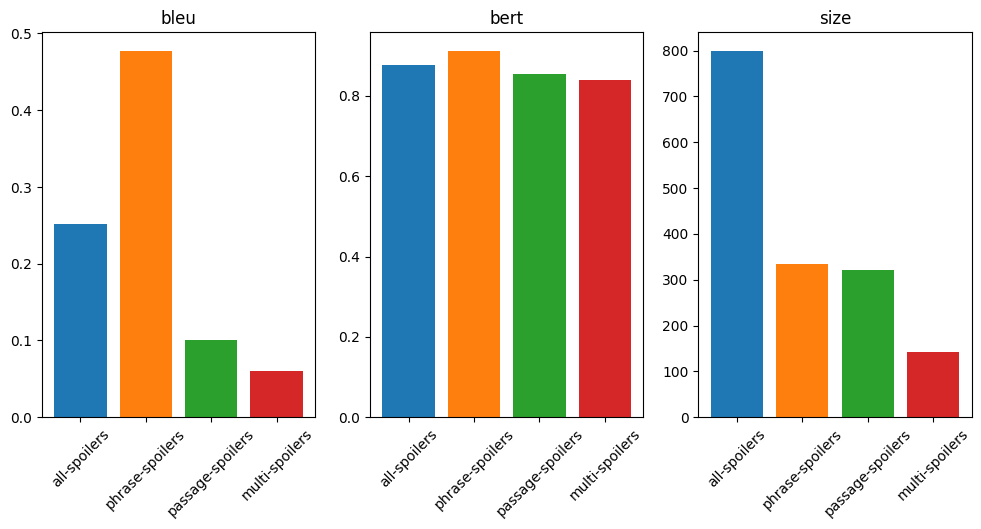

In [7]:
plot_scores(base_scores)

There is definitely room for improvement, some generated spoiler are perfectly correct, but some are totally missed.

#### Finetuning

In [2]:
finetune_roberta('data/train.jsonl', 'data/validation.jsonl')

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

/home/zuzg/anaconda3/envs/nlp/lib/python3.8/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss


In [3]:
run_inference("data/validation.jsonl", "data/preds.jsonl", "data/roberta-finetuned")

Using GPU for pipeline
Using GPU for pipeline


  0%|          | 2/800 [00:00<02:47,  4.76it/s]/home/zuzg/anaconda3/envs/nlp/lib/python3.8/site-packages/transformers/pipelines/base.py:1080: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 800/800 [01:36<00:00,  8.32it/s]


In [ ]:
scores = eval_task_2("data/preds.jsonl", "data/validation.jsonl")

/home/zuzg/deep_learning/clickbait-spoiling/src/evaluation.py:289: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(labels, rotation=45)


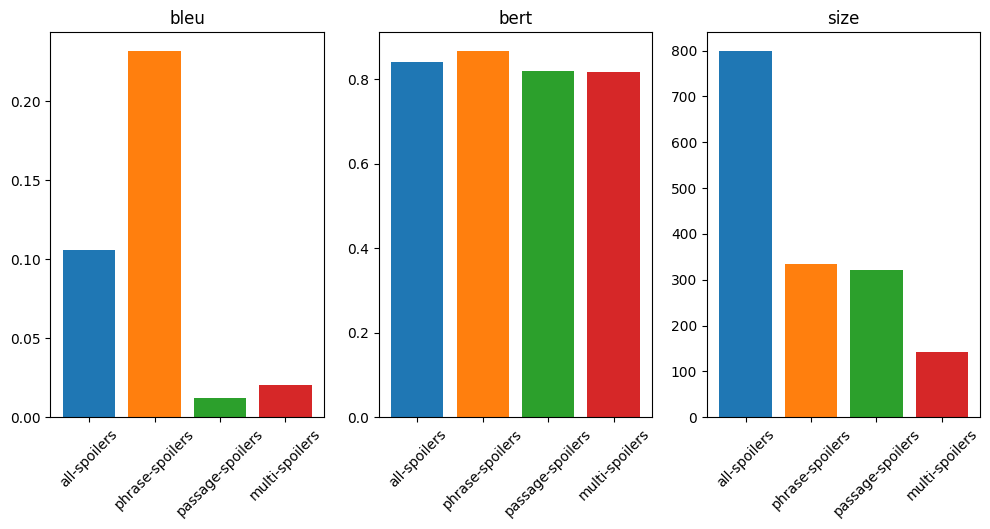

In [5]:
plot_scores(scores)

#### Sample predictions

In [12]:
val = read_spoilers("data/validation.jsonl")
pred = read_spoilers("data/preds.jsonl")

merged = val.merge(pred, on="uuid", suffixes=("_true", "_pred"))
pd.set_option('display.max_colwidth', None)

merged.head(10)

,uuid,spoiler_true,spoiler_pred
0,6dc7ddef-4e8e-4a6b-9296-526377518071,[some of the plot elements are so disturbing that they are making him feel sick],"[Five, too, Nights, , canreworkitentirely]"
1,435b24de-56f6-4d4e-9c38-54b8e0630aac,"[""intentionally"", could transform a court case against Phoenix-area Sheriff Joe Arpaio from civil charges to a criminal prosecution]","["", intentionally, In, a, The]"
2,8091ba93-6376-473a-9117-01d6cf0507e4,[20%],[20]
3,8b713277-0e5b-4873-a216-b650f21f3b4c,"[Alan Rickman & Rupert Grint, CBGB]","["", I, candy, chocolate, Halloween]"
4,a2f91b65-c36c-481f-92b1-2fc77d6411fc,[a man who swallowed a 64GB microSD card and then pooped it into a strainer],"[he, couldn, so, pooped, trefore]"
5,804ba7e2-2e3b-439b-9ee4-6827939c902d,[Sprite],[speeding]
6,d636e94d-d27a-4366-b177-1299c266d7b5,[Smoky Paprika-Baked Garbanzo Beans],[Smoky]
7,cf3cb892-fb30-4210-a525-e5e7aa921082,"[McGonagall was appointed as Dumbledore’s assistant in 1956, not as his replacement.]","[McGonagall, as, Obversa, Professor, ]"
8,a86850fc-047b-432b-bc85-5e198ff4527f,[All the scenes are actually in the movie],"["", No, w, there, All]"
9,ba35ffbc-1eba-4940-8c68-00eefecd2178,"[""I had fake relationships, fake fights. I don't care anymore, I can tell you.]","["", I, What, , ]"


## Query Passage approach for `passages` and `multi`.

For these types of spoilers we used a state-of-the art passage retrieval approach: `MonoT5` and `MonoBERT`. 

What is more, as mentioned in the paper, the QA model is also able to retrieve passages (considering the passage as the returned result from which the question answering model extracts its answer).

In [ ]:
train_df = read_data("data/train.jsonl")
passages_df = train_df[train_df["tags"] == 0]
passages_df.head()

In [14]:
monoBert = MonoBERT()

In [15]:
best_query(passages_df.iloc[1], monoBert)

'Here are seven habits you need instead.'

In [16]:
run_inference("data/validation.jsonl", "data/preds_qr.jsonl", use_pr=True)

Using GPU for pipeline
Using GPU for pipeline


  1%|▏         | 10/800 [00:02<02:18,  5.71it/s]/home/zuzg/anaconda3/envs/nlp/lib/python3.8/site-packages/transformers/pipelines/base.py:1080: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 800/800 [02:32<00:00,  5.24it/s]


In [ ]:
scores = eval_task_2("data/preds_qr.jsonl", "data/validation.jsonl")

/home/zuzg/deep_learning/clickbait-spoiling/src/evaluation.py:289: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(labels, rotation=45)


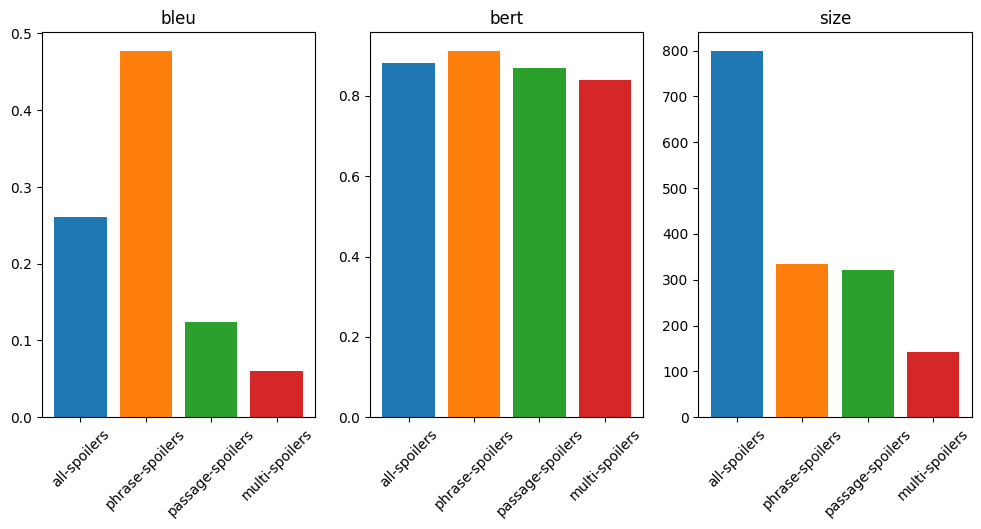

In [18]:
plot_scores(scores)

## Both models combined

In [5]:
run_inference("data/validation.jsonl", "data/preds_final.jsonl", model_qa="data/roberta-finetuned", use_pr=True)
final_scores = eval_task_2("data/preds_final.jsonl", "data/validation.jsonl")

Using GPU for pipeline
Using GPU for pipeline


100%|██████████| 800/800 [02:24<00:00,  5.53it/s]


  [o] The file data/preds_final.jsonl is in JSONL format.
  [o] The file data/validation.jsonl is in JSONL format.
  [o] Spoiler generations have correct format. Found 800
Run evaluation for all-spoilers
  [o] Spoiler generations have correct format. Found 800


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Run evaluation for phrase-spoilers
  [o] Spoiler generations have correct format. Found 335


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Run evaluation for passage-spoilers
  [o] Spoiler generations have correct format. Found 322


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Run evaluation for multi-spoilers
  [o] Spoiler generations have correct format. Found 143


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


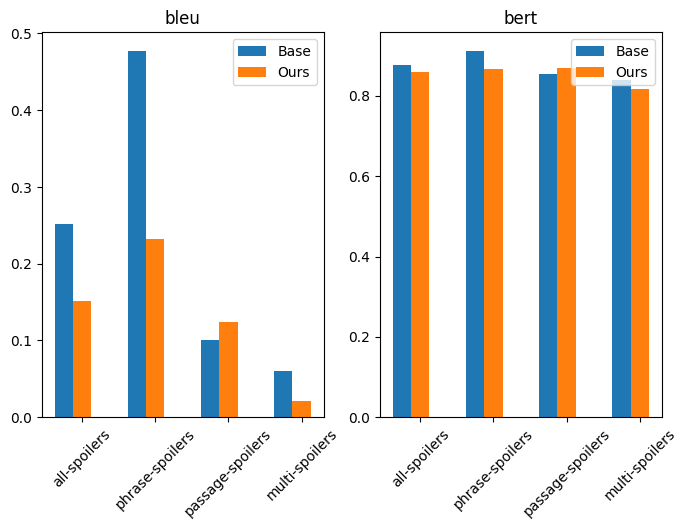

In [12]:
plot_comparison_scores(base_scores, final_scores)

## Merge Spoiler Classificaton with Spoiler Generation 
`postText` : The text of the clickbait post which is to be spoiled.

`targetUrl` : The URL of the linked web page. 

In [19]:
# load the classification model
MODEL_CHECKPOINT = "bert-base-uncased"
PATH = "models/bert_100_epochs.pt"
model = BERTClassifier(MODEL_CHECKPOINT)
model.load_state_dict(torch.load(PATH, map_location=torch.device(DEVICE)))
model.eval();

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
postText = "Is THIS the world's deadliest toxin?"
targetUrl = "http://huff.to/19Tw4Lb"

In [21]:
# YOU CAN SEE PARAGRAPHS SCRAPING HERE 
# target_paragraphs = get_target_paragraphs(targetUrl)
# target_paragraphs

In [22]:
get_spoiler_from_user_input(postText, targetUrl, model)

Target paragraphs (input for spoiler classification):
['National Reporter, HuffPost', "Don't panic, but scientists have stumbled across a new substance that may be the deadliest known to man.", 'A new variant of botulinum toxin, "type H" is so dangerous that researchers have decided to withhold publishing information about it, over concern it could be used as a bioweapon.', 'New Scientist reported that inhaling just 13 billionths of a gram of the stuff, or an injection of just 2 billionths of a gram, could kill an adult. Yikes.', '"This is not the usual process for publishing manuscripts," Dr. David Hooper, an editor at the Journal of Infectious Diseases, told NPR. "We thought in this case an exception was appropriate."', 'Clostridium botulinum, the bacterium that produces the toxic protein, is found in soil. Once ingested, the protein acts as a neurotoxin and can cause a life-threatening paralytic illness known as botulism.', 'C. botulinum has long been known to produce the highly dan

100%|██████████| 1/1 [00:00<00:00,  4.78it/s]

Output:
{'uuid': 'user_input', 'spoiler': ['Clostridium botulinum, the bacterium that produces the toxic protein, is found in soil.']}


{'uuid': 'user_input',
 'spoiler': ['Clostridium botulinum, the bacterium that produces the toxic protein, is found in soil.']}